In [28]:
import re
import datetime
import numpy as np
import pandas as pd

In [29]:
def raw2df(file, key):
    """
    Converts raw .txt file into a Data Frame

    By tusharnankani, taken from github.com/tusharnankani/whatsapp-chat-data-analysis
    """

    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%d/%m/%Y, %I:%M %p - ',
        '24hr' : '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }

    with open(file, 'r', encoding='utf-8') as raw_data:
        # print(raw_data.read())
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns

        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df

    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])

    # split user and msg
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("group_notification")
            msgs.append(a[0])

    # creating new columns
    df['user'] = usernames
    df['message'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)

    return df

<>:9: SyntaxWarning:

invalid escape sequence '\d'

<>:10: SyntaxWarning:

invalid escape sequence '\d'

<>:35: SyntaxWarning:

invalid escape sequence '\w'

<>:9: SyntaxWarning:

invalid escape sequence '\d'

<>:10: SyntaxWarning:

invalid escape sequence '\d'

<>:35: SyntaxWarning:

invalid escape sequence '\w'

C:\Users\saba\AppData\Local\Temp\ipykernel_455316\440162725.py:9: SyntaxWarning:

invalid escape sequence '\d'

C:\Users\saba\AppData\Local\Temp\ipykernel_455316\440162725.py:10: SyntaxWarning:

invalid escape sequence '\d'

C:\Users\saba\AppData\Local\Temp\ipykernel_455316\440162725.py:35: SyntaxWarning:

invalid escape sequence '\w'



In [30]:
initidf = raw2df('data/chats/whatsapp_chat_data_test.txt', '12hr')

In [31]:
df

,date_time,user,message
0,2020-01-26 16:19:00,group_notification,Messages and calls are end-to-end encrypted. N...
1,2020-01-24 20:25:00,group_notification,"Tanay Kamath (TSEC, CS) created group ""CODERS👨..."
2,2020-01-26 16:19:00,group_notification,You joined using this group's invite link
3,2020-01-26 16:20:00,group_notification,+91 99871 38558 joined using this group's invi...
4,2020-01-26 16:20:00,group_notification,+91 91680 38866 joined using this group's invi...
...,...,...,...
13650,2020-10-02 02:05:00,"Darshan Rander (TSEC, IT)",MCQs mark kiya
13651,2020-10-02 02:05:00,"Darshan Rander (TSEC, IT)",Sign-in kiya😂😅
13652,2020-10-02 02:11:00,"Tanay Kamath (TSEC, CS)",Incognito se na?
13653,2020-10-02 02:28:00,"Darshan Rander (TSEC, IT)",Yup


In [32]:
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import plotly.express as px

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

import numpy as np

In [33]:
# Filter out system messages or very short noise
# (Optional but highly recommended for better clustering)
df_clean = df[df['user'] != 'group_notification'].copy()
df_clean = df_clean[df_clean['message'].str.len() > 3] # Filter "ok", "hi", etc?
df_clean = df_clean[~df_clean['message'].str.contains("Media omitted")] # Remove whatsapp media placeholders
# Reset index to match embeddings later
df_clean = df_clean.reset_index(drop=True)

In [34]:
df_clean

,date_time,user,message
0,2020-01-27 19:31:00,+91 96536 93868,Give it a try ....
1,2020-01-27 19:31:00,"Dheeraj Lalwani (TSEC, CS)",Alright
2,2020-01-27 19:32:00,"Dheeraj Lalwani (TSEC, CS)",We can make this a trend
3,2020-01-27 19:32:00,+91 96536 93868,Sure
4,2020-01-27 19:32:00,"Dheeraj Lalwani (TSEC, CS)",Everyday a new challenge
...,...,...,...
10946,2020-10-02 02:05:00,"Darshan Rander (TSEC, IT)",MCQs mark kiya
10947,2020-10-02 02:05:00,"Darshan Rander (TSEC, IT)",Sign-in kiya😂😅
10948,2020-10-02 02:11:00,"Tanay Kamath (TSEC, CS)",Incognito se na?
10949,2020-10-02 02:28:00,"Darshan Rander (TSEC, IT)",Yup


In [35]:
def add_context_window(df, window_back=2, window_fwd=1, time_threshold_minutes=5):
    """
    1. Looks BACK 'window_back' messages.
    2. Looks FORWARD 'window_fwd' messages.
    3. Respects time thresholds for both.
    4. Adds Speaker names.
    5. Repeats the CENTER message to weigh it higher.
    """
    context_msgs = []

    for i in range(len(df)):
        current_row = df.iloc[i]
        current_time = current_row['date_time']

        # --- Backward Context
        back_msgs = []
        for k in range(1, window_back + 1):
            prev_idx = i - k
            if prev_idx < 0: break

            prev_row = df.iloc[prev_idx]
            if (current_time - prev_row['date_time']).total_seconds() / 60 > time_threshold_minutes:
                break

            # Add "User: Message" format
            back_msgs.insert(0, f"{prev_row['user']}: {prev_row['message']}")

        # --- Forward Context
        fwd_msgs = []
        for k in range(1, window_fwd + 1):
            next_idx = i + k
            if next_idx >= len(df): break

            next_row = df.iloc[next_idx]
            if (next_row['date_time'] - current_time).total_seconds() / 60 > time_threshold_minutes:
                break

            fwd_msgs.append(f"{next_row['user']}: {next_row['message']}")

        # --- The Current Message (The Star of the Show)
        # We format it, and we will repeat it to give it "embedding weight"
        center_msg = f"{current_row['user']}: {current_row['message']}"

        # --- Combine
        # Format: [Prev] ... [Prev] ... [CURRENT] ... [CURRENT] ... [Next]
        # We repeat center_msg twice to ensure the cluster is about THIS message,
        # not just the neighbors.
        full_context = back_msgs + [center_msg, center_msg] + fwd_msgs

        # Join with newlines
        context_msgs.append(" \n ".join(full_context))

    return context_msgs

In [36]:
df_clean['context_message'] = add_context_window(df_clean, window_back=2, window_fwd=1, time_threshold_minutes=10)

In [37]:
print("--- Original ---")
print(df_clean['message'].iloc[10])
print("\n--- Contextualized ---")
print(df_clean['context_message'].iloc[10])

--- Original ---
Alright 

--- Contextualized ---
+91 96536 93868: We'll try posting our codes at 10 pm ...  
 Dheeraj Lalwani (TSEC, CS): Alright  
 Dheeraj Lalwani (TSEC, CS): Alright  
 Dheeraj Lalwani (TSEC, CS): Also  Please note  People genuinely interested in coding or Want to start coding only be in this group 


In [38]:
# Load the model
model = SentenceTransformer('all-MiniLM-L6-v2')

# 3. Generate Embeddings
# This might take a moment depending on dataset size
# embeddings = model.encode(df_clean['message'].tolist(), show_progress_bar=True)
embeddings = model.encode(df_clean['context_message'].tolist(), show_progress_bar=True)

print(f"Embedding shape: {embeddings.shape}")

Batches: 100%|██████████| 343/343 [00:48<00:00,  7.07it/s]

Embedding shape: (10951, 384)


In [39]:
# High-Dim UMAP for Clustering
# n_components=5 keeps more info than 2D.
# n_neighbors=30 (higher than default 15) helps preserve global structure better.
umap_cluster_model = umap.UMAP(
    n_neighbors=30,
    n_components=5,
    min_dist=0.0,  # Pack points tightly for clustering
    metric='cosine',
    random_state=42
)
clusterable_embeddings = umap_cluster_model.fit_transform(embeddings)

# Cluster on High-Dim Data
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=30,
    min_samples=3,
    metric='euclidean',
    cluster_selection_method='eom'
)

# We fit on the 5D data, NOT the 2D data
df_clean['topic_cluster'] = clusterer.fit_predict(clusterable_embeddings)

C:\Users\saba\Desktop\projects\Nexus\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [40]:
cluster_labels = df_clean['topic_cluster'] # Define the variable for your snippet

num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f"Found {num_clusters} clusters")
print(f"Messages classified as noise: {list(cluster_labels).count(-1)}")

Found 75 clusters
Messages classified as noise: 4020


In [41]:
# Initialize PCA
pca = PCA(n_components=2)

# Transform the data to lower dims
viz_pca = pca.fit_transform(clusterable_embeddings)

# Update the DataFrame
df_clean['x'] = viz_pca[:, 0]
df_clean['y'] = viz_pca[:, 1]

In [42]:
df_clean

,date_time,user,message,context_message,topic_cluster,x,y
0,2020-01-27 19:31:00,+91 96536 93868,Give it a try ....,+91 96536 93868: Give it a try .... \n +91 96...,63,0.384362,0.920379
1,2020-01-27 19:31:00,"Dheeraj Lalwani (TSEC, CS)",Alright,+91 96536 93868: Give it a try .... \n Dheera...,63,0.328809,0.891886
2,2020-01-27 19:32:00,"Dheeraj Lalwani (TSEC, CS)",We can make this a trend,+91 96536 93868: Give it a try .... \n Dheera...,63,0.420861,0.927167
3,2020-01-27 19:32:00,+91 96536 93868,Sure,"Dheeraj Lalwani (TSEC, CS): Alright \n Dheera...",-1,1.355682,0.920084
4,2020-01-27 19:32:00,"Dheeraj Lalwani (TSEC, CS)",Everyday a new challenge,"Dheeraj Lalwani (TSEC, CS): We can make this a...",-1,1.209082,0.818630
...,...,...,...,...,...,...,...
10946,2020-10-02 02:05:00,"Darshan Rander (TSEC, IT)",MCQs mark kiya,"Tanay Kamath (TSEC, CS): Bhai lab pe 5-10 mins...",69,1.066820,0.877722
10947,2020-10-02 02:05:00,"Darshan Rander (TSEC, IT)",Sign-in kiya😂😅,"Darshan Rander (TSEC, IT): 7mins ig \n Darsha...",-1,0.796962,0.596788
10948,2020-10-02 02:11:00,"Tanay Kamath (TSEC, CS)",Incognito se na?,"Darshan Rander (TSEC, IT): MCQs mark kiya \n ...",-1,0.799791,0.616998
10949,2020-10-02 02:28:00,"Darshan Rander (TSEC, IT)",Yup,"Darshan Rander (TSEC, IT): Yup \n Darshan Ran...",72,1.090015,0.436262


In [43]:
fig = px.scatter(
    df_clean,
    x='x',
    y='y',
    color=df_clean['topic_cluster'].astype(str),
    hover_data=['user', 'message'],
    title="Chat Topics: 5D Clustering projected on 2D",
    template="plotly_dark"
)
fig.update_traces(marker=dict(size=5))
fig.show()

In [44]:
# Look at a specific cluster (e.g., Cluster 1)
cluster_id = 71
print(f"--- Messages in Cluster {cluster_id} ---")
print(df_clean[df_clean['topic_cluster'] == cluster_id]['message'].head(10).values)

--- Messages in Cluster 71 ---
['This is an amazing problem ' 'Try it '
 'For those students who want to start right from the scratch '
 'Basically ' 'Some one who solves CodeChef ? '
 "It'll be awesome if u shared your journey "
 'How you  started and how didi u think this through '
 'Please never take this man seriously🙏🏻 '
 'I know everyone has its own different paths '
 'Also, Did anyone do this?? ']


In [45]:
# Count messages per cluster (excluding Noise -1 if you want)
cluster_counts = df_clean['topic_cluster'].value_counts().reset_index()
cluster_counts.columns = ['topic_cluster', 'count']

# Sort by cluster ID or size
cluster_counts = cluster_counts.sort_values('count', ascending=False)

fig = px.bar(
    cluster_counts,
    x='topic_cluster',
    y='count',
    title="Cluster Size Distribution",
    labels={'topic_cluster': 'Cluster ID', 'count': 'Number of Messages'},
    template="plotly_dark"
)

# Optional: Highlight the "Noise" cluster (-1) if it exists
fig.update_traces(marker_color=['red' if x == -1 else 'cornflowerblue' for x in cluster_counts['topic_cluster']])

fig.show()

In [46]:
# Remove noise cluster (-1)
df_no_noise = df_clean[df_clean['topic_cluster'] != -1]

# Count messages per cluster
cluster_counts = (
    df_no_noise['topic_cluster']
    .value_counts()
    .reset_index()
)

cluster_counts.columns = ['topic_cluster', 'count']

# Sort by size
cluster_counts = cluster_counts.sort_values('count', ascending=False)

fig = px.bar(
    cluster_counts,
    x='topic_cluster',
    y='count',
    title="Cluster Size Distribution (Noise Removed)",
    labels={'topic_cluster': 'Cluster ID', 'count': 'Number of Messages'},
    template="plotly_dark"
)

fig.show()

In [47]:
def plot_wordcloud(cluster_id, df):
    # Filter messages for this cluster
    subset = df[df['topic_cluster'] == cluster_id]

    if len(subset) == 0:
        print(f"Cluster {cluster_id} is empty.")
        return

    # Join all messages into one big text blob
    text = " ".join(subset['message'].tolist())

    # Generate Word Cloud
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Cluster {cluster_id}")
    plt.show()

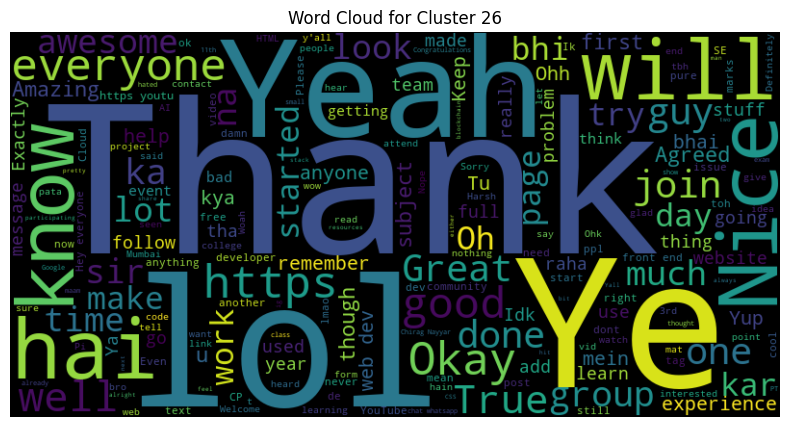

In [48]:
# Try it out on a specific cluster
plot_wordcloud(26, df_clean)  # Change 0 to any cluster ID

In [49]:
def get_most_representative_messages(cluster_id, df, embeddings, n=3):
    # Get indices of messages in this cluster
    cluster_indices = df.index[df['topic_cluster'] == cluster_id].tolist()

    if not cluster_indices:
        return []

    # Extract embeddings for this cluster
    cluster_embeddings = embeddings[cluster_indices]

    # Calculate the Centroid (average embedding)
    centroid = np.mean(cluster_embeddings, axis=0).reshape(1, -1)

    # Calculate similarity of every message in this cluster to the centroid
    similarities = cosine_similarity(centroid, cluster_embeddings).flatten()

    # Get top N most similar messages
    top_indices = np.argsort(similarities)[-n:][::-1] # indices within the subset

    print(f"\n--- Cluster {cluster_id} Representative Messages ---")
    for i in top_indices:
        original_idx = cluster_indices[i]
        print(f"[{similarities[i]:.4f}] {df.loc[original_idx, 'message']}")

In [50]:
# Run this loop to check your top k biggest clusters
top_clusters = df_clean['topic_cluster'].value_counts().head(100).index.tolist()

for cid in top_clusters:
    if cid != -1: # Skip noise
        get_most_representative_messages(cid, df_clean, embeddings)


--- Cluster 26 Representative Messages ---
[0.9153] 💯💯🙌🏻 
[0.9124] WOW! 
[0.9102] Yes 

--- Cluster 40 Representative Messages ---
[0.9148] 🔥🔥🔥 
[0.9138] 😂😂😂 
[0.9079] 👌🏼👍🏼 

--- Cluster 25 Representative Messages ---
[0.9001] Follow up for this 
[0.8978] Yup 
[0.8946] 😅😂👍 

--- Cluster 12 Representative Messages ---
[0.8271] int main() {   int n;   cin>>n;   for (int i=1;i<=n;i++){       for(int j=1;j<=n+1-i;j++){           cout<<"*";       }       for (int k=1;k<=2*i-2;k++){           cout<<" ";       }       for(int j=1;j<=n+1-i;j++){           cout<<"*";       }cout<<endl;   }   for(int i=1;i<=n;i++){       for(int j=1;j<=i;j++){           cout<<"*";       }       for(int k=1;k<=2*(n-i);k++){           cout<<" ";           }           for (int j=1;j<=i;j++){               cout<<"*";           }cout<<endl;   } 
[0.8202] Shit 
[0.8179] This is my approach 

--- Cluster 56 Representative Messages ---
[0.8669] Yaa truly 
[0.8597] Really good 
[0.8506] who he? 

--- Cluster 71 Represen

In [56]:
# Filter out noise (-1) if needed
df_plot = df_clean[df_clean['topic_cluster'] != -1].copy()
# df_plot = df_clean

# Sort by cluster for better coloring
df_plot = df_plot.sort_values('topic_cluster')

fig = px.scatter(
    df_plot,
    x='date_time',
    y='topic_cluster',
    color=df_plot['topic_cluster'].astype(str),
    hover_data=['message'],
    title="Timeline of Topics (Do they recur?)",
    template="plotly_dark",
    height=600
)

# Make dots bigger
fig.update_traces(marker=dict(size=5))
fig.show()

In [52]:
# Group by Cluster and get min/max time
topic_lifetimes = df_clean[df_clean['topic_cluster'] != -1].groupby('topic_cluster')['date_time'].agg(['min', 'max', 'count'])

# Calculate duration
topic_lifetimes['duration'] = topic_lifetimes['max'] - topic_lifetimes['min']

# Sort by longest duration (The "Recurring Topics")
print(topic_lifetimes.sort_values('duration', ascending=False).head(10))

                              min                 max  count          duration
topic_cluster                                                                 
40            2020-01-27 19:59:00 2020-10-01 11:32:00    304 247 days 15:33:00
72            2020-01-28 15:19:00 2020-10-02 02:28:00     85 247 days 11:09:00
46            2020-01-28 19:00:00 2020-10-02 01:25:00     86 247 days 06:25:00
47            2020-01-27 22:15:00 2020-09-30 23:20:00    149 247 days 01:05:00
17            2020-01-28 01:04:00 2020-09-30 23:08:00     48 246 days 22:04:00
64            2020-01-29 19:51:00 2020-10-02 01:47:00    139 246 days 05:56:00
63            2020-01-27 19:31:00 2020-09-30 01:05:00    132 246 days 05:34:00
54            2020-01-28 19:29:00 2020-09-30 20:21:00     36 246 days 00:52:00
2             2020-01-28 19:24:00 2020-09-30 11:02:00     57 245 days 15:38:00
71            2020-01-30 20:44:00 2020-10-02 10:13:00    213 245 days 13:29:00


In [53]:
# Taking Cluster ID that had a long duration
cluster_id = 72

subset = df_clean[df_clean['topic_cluster'] == cluster_id].sort_values('date_time')

print(f"--- Evolution of Cluster {cluster_id} ---")
print(f"(0) msg: {subset.iloc[0]['date_time']} | {subset.iloc[0]['message']}")
print(f"(1) msg: {subset.iloc[1]['date_time']} | {subset.iloc[1]['message']}")
print(f"(2) msg: {subset.iloc[2]['date_time']} | {subset.iloc[2]['message']}")
print(f" ... ")
print(f"({len(subset)//2}) Middle msg: {subset.iloc[len(subset)//2]['date_time']} | {subset.iloc[len(subset)//2]['message']}")
print(f" ... ")
print(f"(-3) msg:  {subset.iloc[-3]['date_time']} | {subset.iloc[-3]['message']}")
print(f"(-2) msg:  {subset.iloc[-2]['date_time']} | {subset.iloc[-2]['message']}")
print(f"(-1) msg:  {subset.iloc[-1]['date_time']} | {subset.iloc[-1]['message']}")

--- Evolution of Cluster 72 ---
(0) msg: 2020-01-28 15:19:00 | Y u used abs?? 
(1) msg: 2020-01-30 18:14:00 | Aaj ka sawal?? 
(2) msg: 2020-02-23 11:17:00 | side mein option hai 
 ... 
(42) Middle msg: 2020-05-28 09:40:00 | Yes duckduckgo is default 
 ... 
(-3) msg:  2020-09-28 17:58:00 | Ha re 😅 
(-2) msg:  2020-09-30 23:27:00 | Arre ye kese bhula mein🤦‍♂️😂 
(-1) msg:  2020-10-02 02:28:00 | Yup 


In [54]:
def extract_cluster_keywords(df, docs_col='message', cluster_col='topic_cluster', n_keywords=5):
    # Group all messages in a cluster into one giant string
    docs_per_class = df.groupby(cluster_col)[docs_col].apply(lambda x: " ".join(x))

    # Use CountVectorizer to count words (ignoring standard English stopwords)
    # We add custom stopwords like 'ok', 'yeah' if needed
    count = CountVectorizer(stop_words='english', min_df=5)
    count_matrix = count.fit_transform(docs_per_class)
    features = count.get_feature_names_out()

    # Extract top words for each cluster
    keywords = {}
    for i, cluster_id in enumerate(docs_per_class.index):
        if cluster_id == -1: continue # Skip noise

        # Get row for this cluster
        row = count_matrix[i].toarray().flatten()

        # Sort indices by count (descending)
        top_indices = row.argsort()[-n_keywords:][::-1]

        # Get actual words
        top_words = [features[ind] for ind in top_indices]
        keywords[cluster_id] = top_words

    return keywords

# Run it
cluster_keywords = extract_cluster_keywords(df_clean)

# Print the top 10 biggest clusters and their keywords
top_clusters = df_clean['topic_cluster'].value_counts().head(10).index
for cid in top_clusters:
    if cid != -1:
        print(f"Cluster {cid}: {cluster_keywords.get(cid, [])}")

Cluster 26: ['thank', 'lol', 'yes', 'https', 'yeah']
Cluster 40: ['https', 'thanks', 'just', 'youtu', 'com']
Cluster 25: ['yes', 'watch', 'yeah', 'time', 'coding']
Cluster 12: ['int', 'printf', 'return', 'include', 'main']
Cluster 56: ['cp', 'https', 'codechef', 'com', 'questions']
Cluster 71: ['https', 'com', 'guys', 'youtube', 'watch']
Cluster 24: ['think', 'just', 'want', 'given', 'people']
Cluster 6: ['deleted', 'message', 'hai', 'guys', 'using']
Cluster 51: ['true', 'false', 'yes', 'int', 'type']
